### Import libraries

In [27]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)


2.10.0


### Set seed for reproducibility

In [28]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

 # Load the training dataset

In [29]:
path = os.getcwd()
# Load the .npy file
X = np.load(path+r'\training\x_train.npy')
y = np.load(path+r'\training\y_train.npy')
print(X.shape)   #Note as sequences are already built, with window 36
print(y.shape)
print(X.dtype)
print(y.dtype)

(2429, 36, 6)
(2429,)
float64
int32


In [30]:
# visualizing X and y
print(X)
print(y)     

[[[ 1.7597e+01  8.1713e+00 -1.7842e+00 -1.9706e+01 -9.7135e+00
   -6.1887e+01]
  [ 2.2974e-01 -5.8956e+00  1.6837e+01  5.0390e+00  2.4332e+00
    5.8914e+01]
  [-2.9654e+01 -2.1296e+01  2.9103e+01 -4.7503e-01  7.5391e+01
    1.0665e+01]
  ...
  [ 1.1982e+02  2.1849e+02  1.6398e+03  5.9787e+02  2.1922e+03
    1.8484e+01]
  [ 9.1591e+01  1.0378e+02  1.8238e+03  1.2460e+03  1.1301e+04
    7.5107e+02]
  [ 4.3719e+01  3.0689e+01  9.5092e+02  8.5927e+02  8.1331e+03
    9.8883e+02]]

 [[ 2.4209e+00 -5.6039e-01  2.3654e+01 -3.8171e+00  1.3721e+00
    8.2510e+00]
  [ 1.6847e+00  2.3989e+01  1.7803e+01 -1.9575e+01 -8.2534e+00
   -2.3959e+01]
  [ 5.0692e-01  5.0281e+01  5.1196e+01  1.6036e+01  7.2974e-01
   -1.8185e+01]
  ...
  [-1.5618e+01 -7.4233e+00  3.7833e+00  1.6565e+00 -1.0438e+01
   -5.5229e+00]
  [-1.0702e+01 -6.3568e+00 -4.6464e+00  6.7957e-01 -5.5260e+00
    1.9070e+01]
  [-4.6352e+00 -3.2769e+00 -5.9048e+00 -1.9564e-01  1.1487e+00
    2.3275e+01]]

 [[ 3.9688e+01  7.0129e+02  3.0038e+

## Train-test split

In [31]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
print(X_train.shape)
print(y_train)
print(X_test.shape)

(1943, 36, 6)
[3 9 6 ... 9 1 5]
(486, 36, 6)


In [32]:
scaler = MinMaxScaler()
X_train_2d = np.reshape(X_train, (1943, 36 * 6))
X_test_2d = np.reshape(X_test, (486, 36 * 6))
# Fit the scaler to the training data and apply the scaling on the training data
X_train = scaler.fit_transform(X_train_2d)
# Apply the scaling on validation data
X_test = scaler.transform(X_test_2d)
#Getting back to orginal shape
X_train = np.reshape(X_train, (1943, 36, 6))
X_test = np.reshape(X_test, (486, 36, 6))


In [33]:
# Convert the sparse labels to categorical values
y_train = tfk.utils.to_categorical(y_train)
y_test = tfk.utils.to_categorical(y_test)
print(y_train.shape)
print(y_test.shape)

(1943, 12)
(486, 12)


In [34]:
# Map classes STRINGS to integers
label_mapping = {
    'Wish': 0,
    'Another': 1,
    'Comfortably': 2,
    'Money': 3,
    'Breathe': 4,
    'Time': 5,
    'Brain': 6,
    'Echoes': 7,
    'Wearing': 8,
    'Sorrow': 9,
    'Hey': 10,
    'Shine': 11,  
}

## Build the models

In [35]:
input_shape = X_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 128
epochs = 200


#### Vanilla Long Short Term Memory (LSTM) Neural Network

In [36]:
def build_LSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    lstm = tfkl.LSTM(128, return_sequences=True)(input_layer)    # return_sequences=True -> output = batch_size * timestamps * features
                                                                 # return_sequences=False -> output = batch_size * 1 (just last timestamp) * features
    lstm = tfkl.LSTM(128)(lstm)
    dropout = tfkl.Dropout(.5, seed=seed)(lstm)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [37]:
model = build_LSTM_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 36, 128)           69120     
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 12)                1548      
                                                                 
Total params: 218,764
Trainable params: 218,764
Non-trainable

In [38]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
14/14 [==============================] - 5s 56ms/step - loss: 2.2724 - accuracy: 0.2975 - val_loss: 2.0789 - val_accuracy: 0.3128 - lr: 0.0010
Epoch 2/200
14/14 [==============================] - 0s 12ms/step - loss: 2.1215 - accuracy: 0.3181 - val_loss: 2.0497 - val_accuracy: 0.3128 - lr: 0.0010
Epoch 3/200
14/14 [==============================] - 0s 11ms/step - loss: 2.1073 - accuracy: 0.3209 - val_loss: 2.0349 - val_accuracy: 0.3128 - lr: 0.0010
Epoch 4/200
14/14 [==============================] - 0s 11ms/step - loss: 2.1031 - accuracy: 0.3209 - val_loss: 2.0297 - val_accuracy: 0.3128 - lr: 0.0010
Epoch 5/200
14/14 [==============================] - 0s 11ms/step - loss: 2.0993 - accuracy: 0.3209 - val_loss: 2.0289 - val_accuracy: 0.3128 - lr: 0.0010
Epoch 6/200
14/14 [==============================] - 0s 11ms/step - loss: 2.1036 - accuracy: 0.3209 - val_loss: 2.0345 - val_accuracy: 0.3128 - lr: 0.0010
Epoch 7/200
14/14 [==============================] - 0s 10ms/step - lo

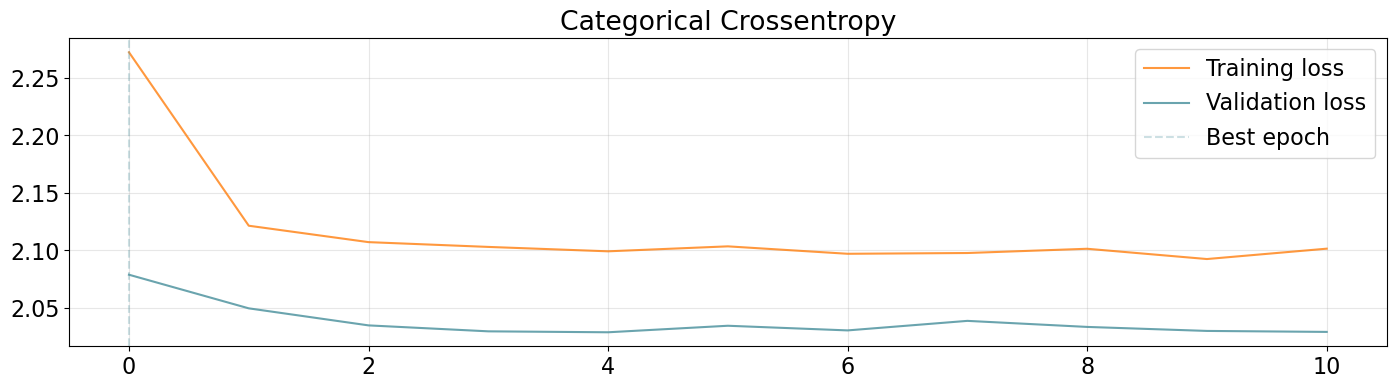

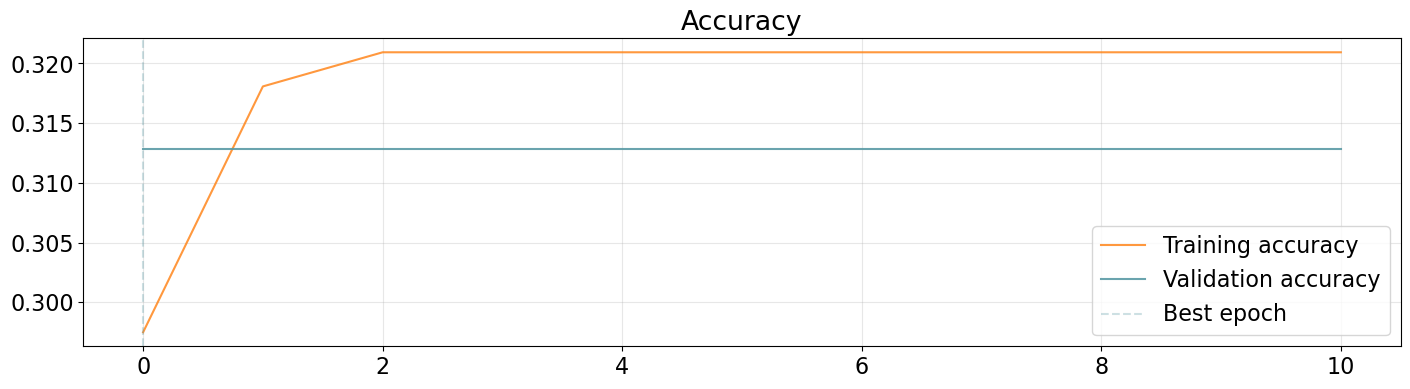

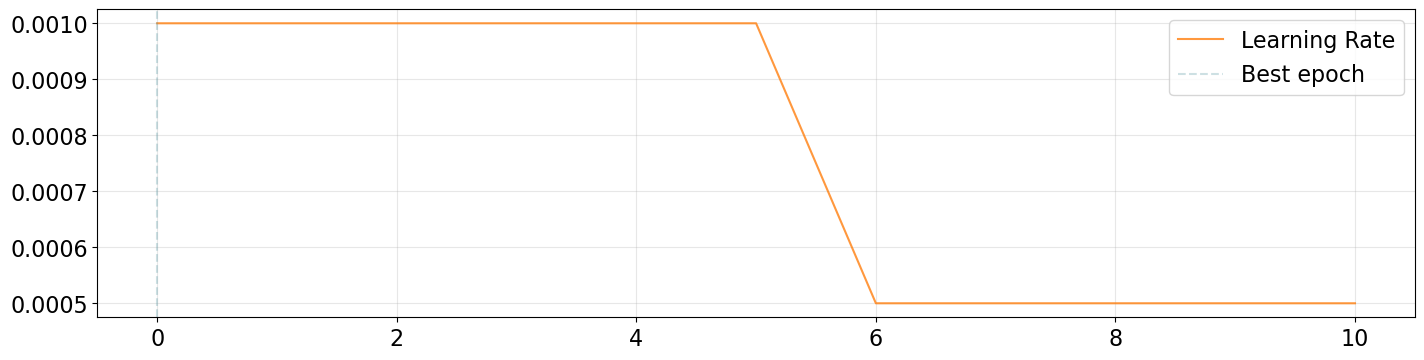

In [39]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [40]:
# Predict the test set with the LSTM
predictions = model.predict(X_test)
predictions.shape

16/16 [==============================] - 1s 3ms/step


(486, 12)

Accuracy: 0.3189
Precision: 0.0266
Recall: 0.0833
F1: 0.0403


c:\Users\Gabriele\miniconda3\envs\gputensorflow\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


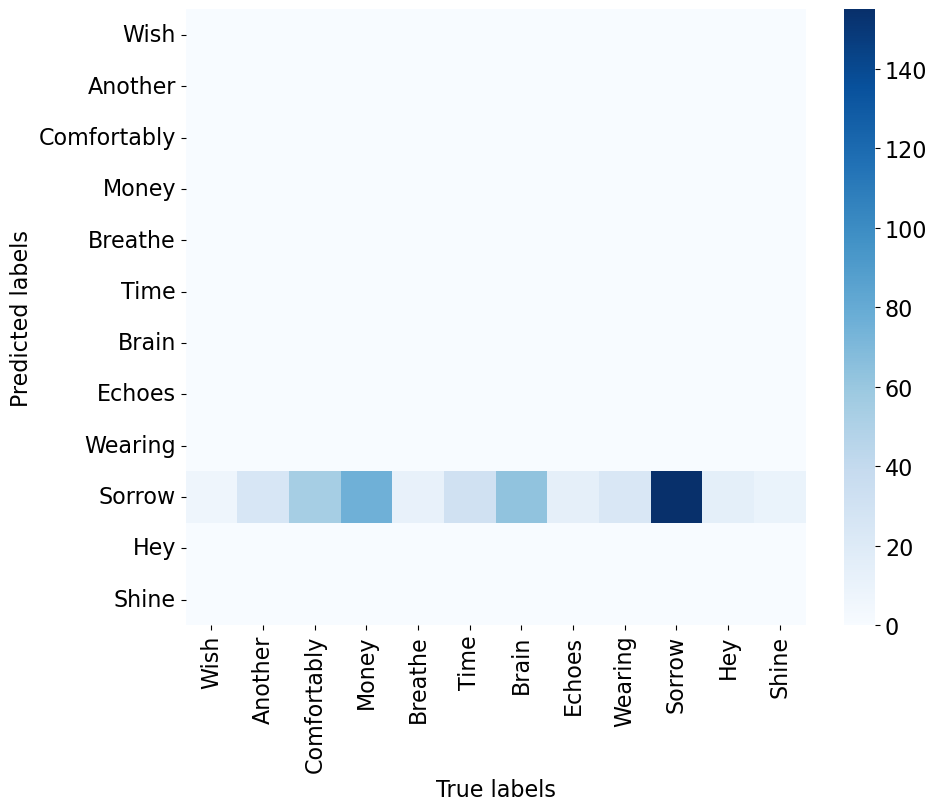

In [41]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

#### Bidirectional Long Short Term Memory (BiLSTM) Neural Network

In [42]:
def build_BiLSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(input_layer)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128))(bilstm)
    dropout = tfkl.Dropout(.5, seed=seed)(bilstm)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [43]:
model = build_BiLSTM_classifier(input_shape, classes)
model.summary() #note double number of parameters (this is because we have 2 lstm)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 36, 256)          138240    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 12)                1548  

In [44]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
14/14 [==============================] - 5s 92ms/step - loss: 2.2251 - accuracy: 0.2826 - val_loss: 2.0431 - val_accuracy: 0.3128 - lr: 0.0010
Epoch 2/200
14/14 [==============================] - 0s 18ms/step - loss: 2.1140 - accuracy: 0.3198 - val_loss: 2.0510 - val_accuracy: 0.3128 - lr: 0.0010
Epoch 3/200
14/14 [==============================] - 0s 18ms/step - loss: 2.1035 - accuracy: 0.3209 - val_loss: 2.0348 - val_accuracy: 0.3128 - lr: 0.0010
Epoch 4/200
14/14 [==============================] - 0s 18ms/step - loss: 2.1069 - accuracy: 0.3209 - val_loss: 2.0519 - val_accuracy: 0.3128 - lr: 0.0010
Epoch 5/200
14/14 [==============================] - 0s 18ms/step - loss: 2.1058 - accuracy: 0.3209 - val_loss: 2.0373 - val_accuracy: 0.3128 - lr: 0.0010
Epoch 6/200
14/14 [==============================] - 0s 18ms/step - loss: 2.1049 - accuracy: 0.3209 - val_loss: 2.0377 - val_accuracy: 0.3128 - lr: 0.0010
Epoch 7/200
14/14 [==============================] - 0s 18ms/step - lo

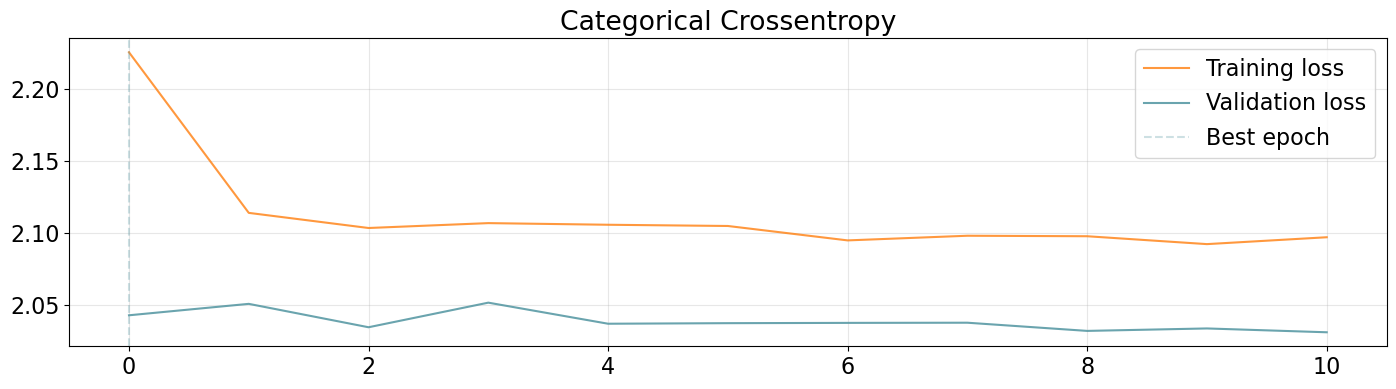

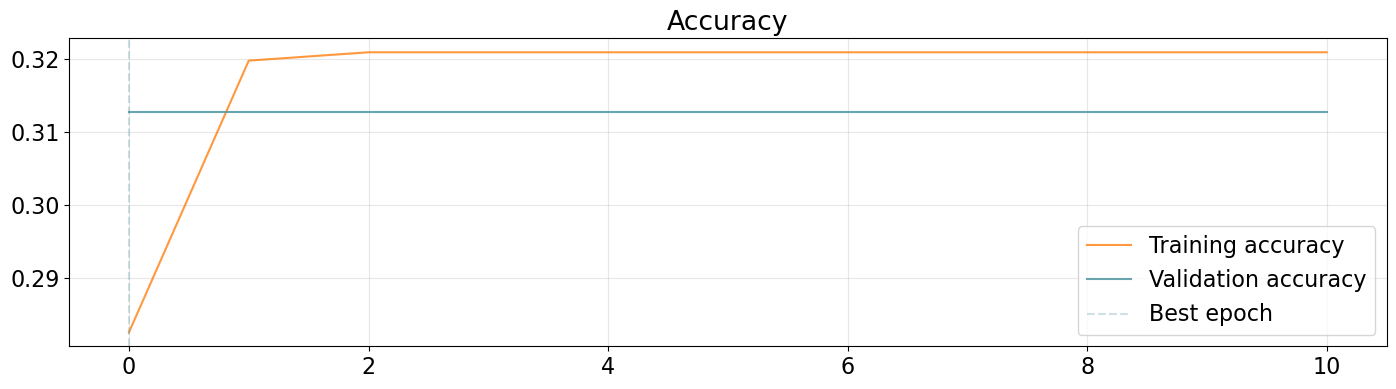

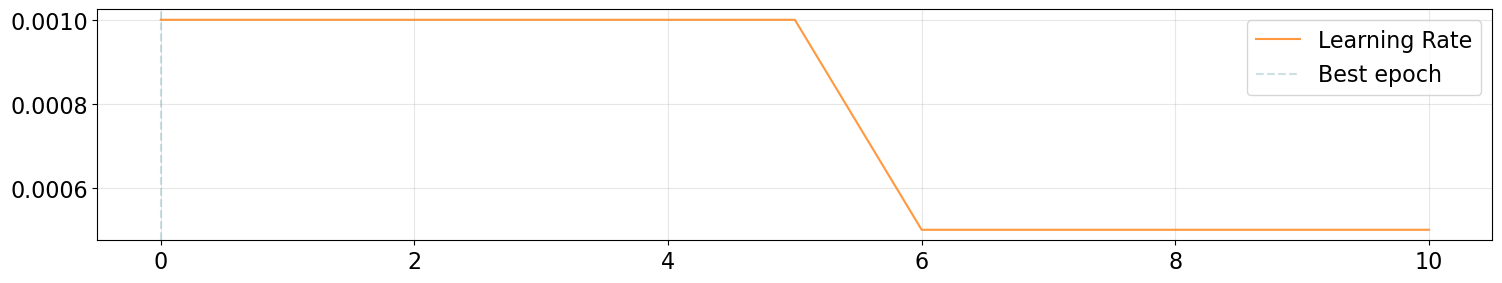

In [45]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [46]:
# Predict the test set with the BiLSTM
predictions = model.predict(X_test)
predictions.shape

16/16 [==============================] - 1s 4ms/step


(486, 12)

Accuracy: 0.3189
Precision: 0.0266
Recall: 0.0833
F1: 0.0403


c:\Users\Gabriele\miniconda3\envs\gputensorflow\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


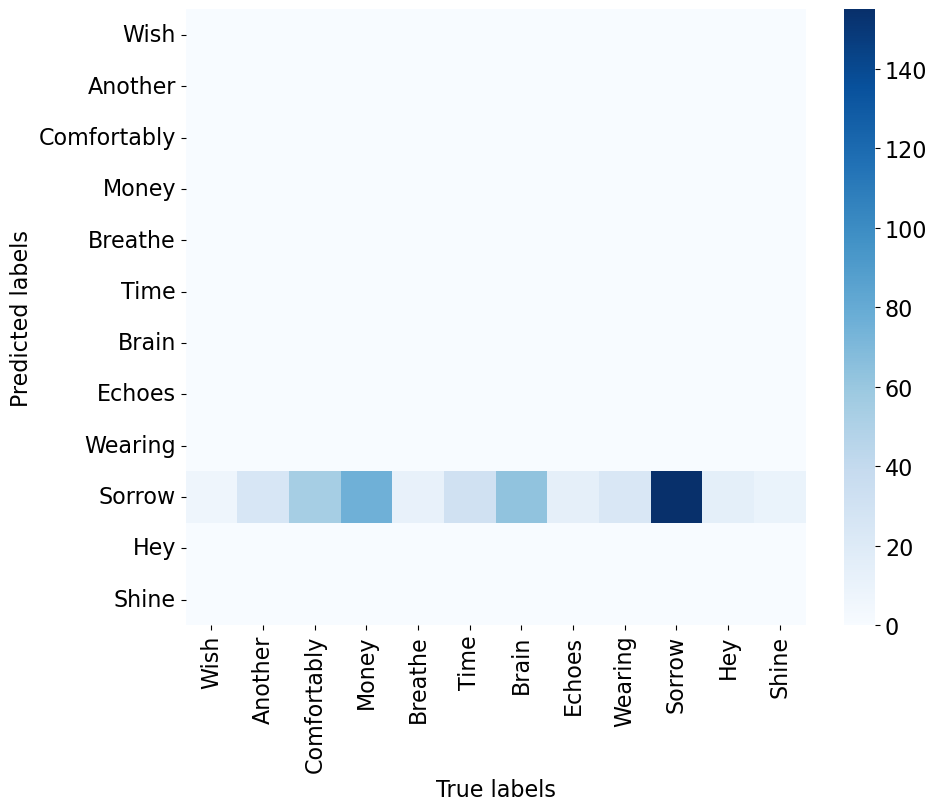

In [47]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

#### 1D Convolutional Neural Network

In [48]:
def build_1DCNN_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.5, seed=seed)(gap)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [49]:
model = build_1DCNN_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 conv1d (Conv1D)             (None, 36, 128)           2432      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 18, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 18, 128)           49280     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_2 (Dropout)         (None, 128)               0     

In [50]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
14/14 [==============================] - 2s 20ms/step - loss: 2.2981 - accuracy: 0.2546 - val_loss: 2.0816 - val_accuracy: 0.3128 - lr: 0.0010
Epoch 2/200
14/14 [==============================] - 0s 5ms/step - loss: 2.1270 - accuracy: 0.3209 - val_loss: 2.0680 - val_accuracy: 0.3128 - lr: 0.0010
Epoch 3/200
14/14 [==============================] - 0s 6ms/step - loss: 2.1124 - accuracy: 0.3209 - val_loss: 2.0279 - val_accuracy: 0.3128 - lr: 0.0010
Epoch 4/200
14/14 [==============================] - 0s 6ms/step - loss: 2.1073 - accuracy: 0.3209 - val_loss: 2.0400 - val_accuracy: 0.3128 - lr: 0.0010
Epoch 5/200
14/14 [==============================] - 0s 5ms/step - loss: 2.1013 - accuracy: 0.3209 - val_loss: 2.0396 - val_accuracy: 0.3128 - lr: 0.0010
Epoch 6/200
14/14 [==============================] - 0s 6ms/step - loss: 2.1018 - accuracy: 0.3209 - val_loss: 2.0416 - val_accuracy: 0.3128 - lr: 0.0010
Epoch 7/200
14/14 [==============================] - 0s 5ms/step - loss: 2.

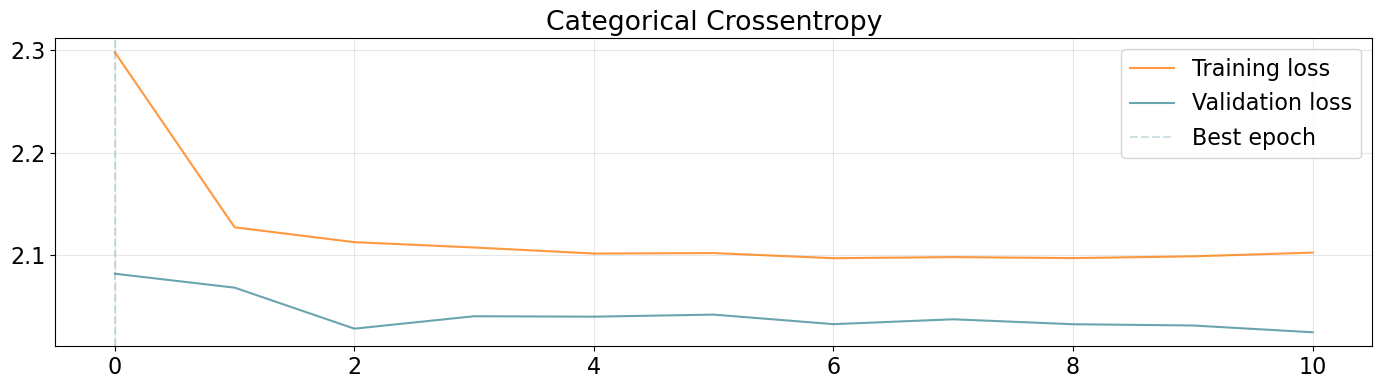

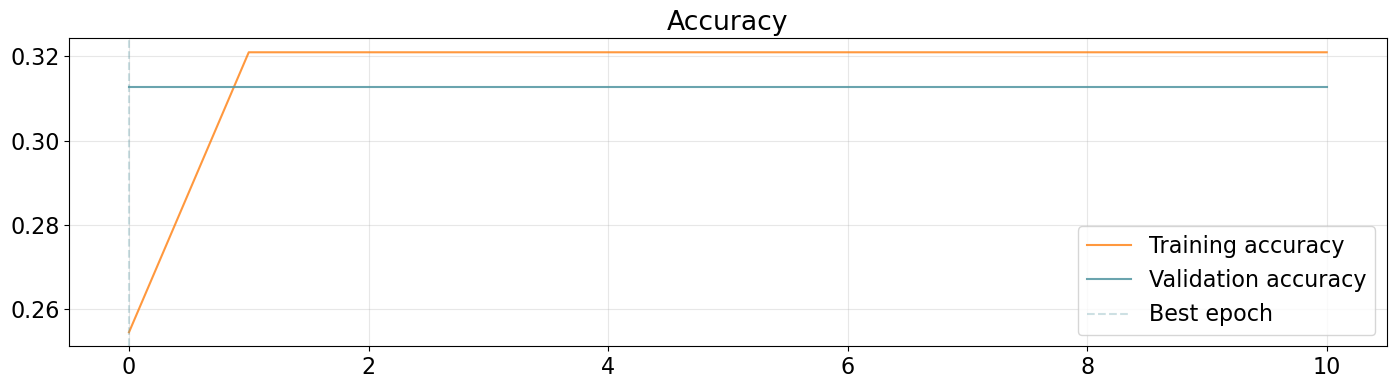

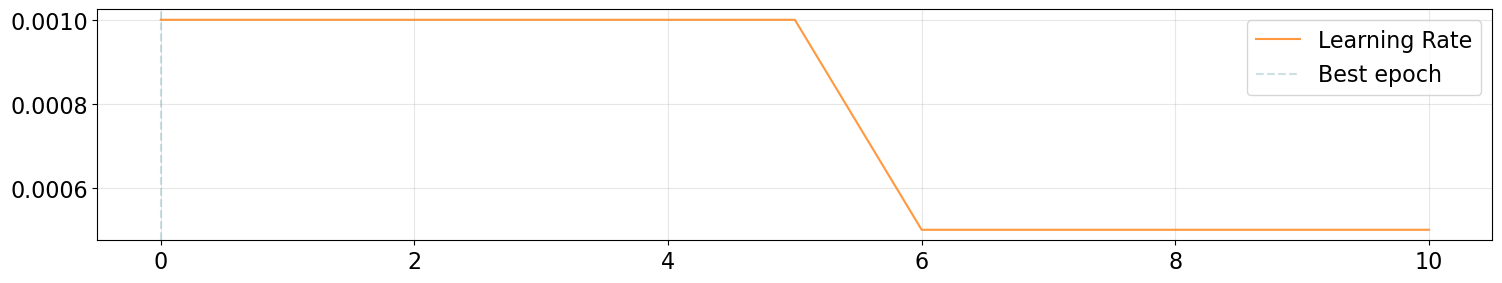

In [51]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [52]:
# Predict the test set with the 1DCNN
predictions = model.predict(X_test)
predictions.shape

16/16 [==============================] - 0s 2ms/step


(486, 12)

Accuracy: 0.3189
Precision: 0.0266
Recall: 0.0833
F1: 0.0403


c:\Users\Gabriele\miniconda3\envs\gputensorflow\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


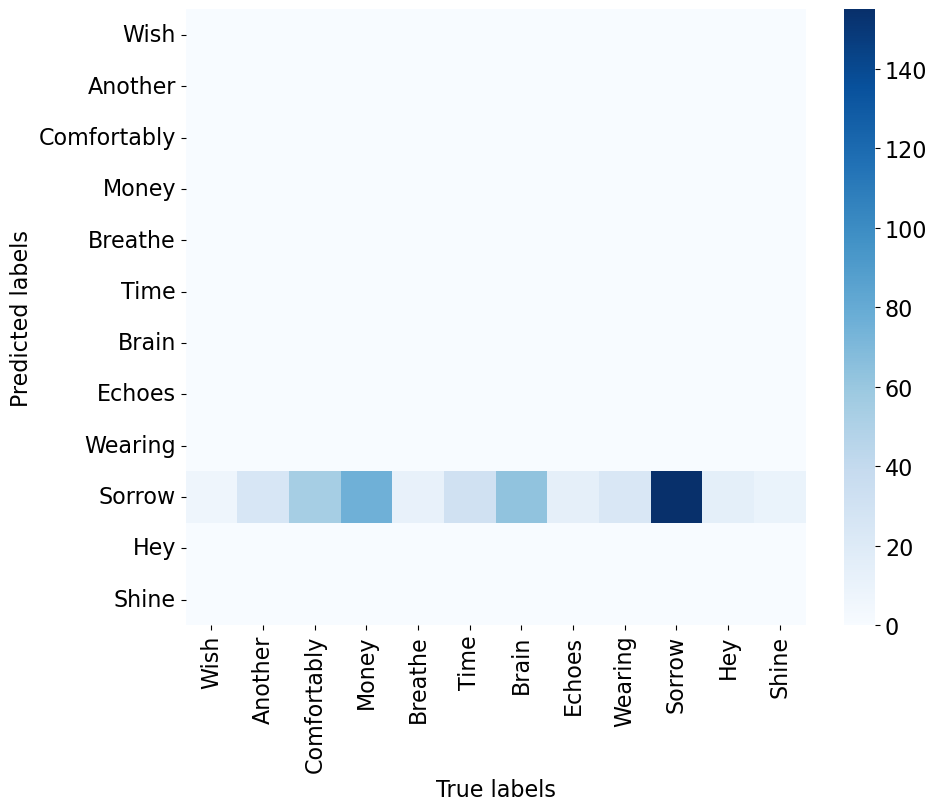

In [53]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()